In [1]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import os
from tqdm import tqdm

C:\Users\anuar\anaconda3\envs\dl\Lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# Set configuration and select device

# Training hyperparameters
BATCH_SIZE    = 1      # batch size
LR            = 1e-3     # learning rate
EPOCHS        = 60       # number of training epochs

# Dataset info 
PAST_STEPS    = 8        # number of past steps used as input
FUTURE_STEPS  = 12       # number of future steps to predict
INPUT_DIM     = 2        # (x,y)
OUTPUT_DIM    = 2        # (x,y)

# Device selection: cuda if GPU is available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Download the preprocessed `.npz` dataset from Google Drive

NPZ_FILE_ID   = "1QJ8AbZyy1_h_UkRDLSPL_oFmsX8aimcU" 
OUT_NPZ_PATH  = "evac_P8F12_P5features_100runs.npz"

if not os.path.exists(OUT_NPZ_PATH):
    url = f"https://drive.google.com/uc?id={NPZ_FILE_ID}"
    print("⬇️ Downloading dataset from:", url)
    gdown.download(url, OUT_NPZ_PATH, quiet=False)
else:
    print("📂 Dataset already exists at:", OUT_NPZ_PATH)

print("✅ Dataset ready at:", OUT_NPZ_PATH)

📂 Dataset already exists at: evac_P8F12_P5features_100runs_XYemotionVAL.npz
✅ Dataset ready at: evac_P8F12_P5features_100runs_XYemotionVAL.npz


In [4]:
# Load and inspect the `.npz` dataset

data = np.load(OUT_NPZ_PATH)

X_train = data["X_train"]  # shape: (N_train, 8, 5)
Y_train = data["Y_train"].reshape(data["Y_train"].shape[0], FUTURE_STEPS, 2)   # shape: (N_train, 12, 2)
X_test  = data["X_test"]   # shape: (N_test, 8, 5)
Y_test  = data["Y_test"].reshape(data["Y_test"].shape[0], FUTURE_STEPS, 2)   # shape: (N_train, 12, 2)

# Slice to keep only X and Y features
X_train = X_train[:, :, :2]  # shape: (N_train, 16)
X_test  = X_test[:, :, :2]    # shape: (N_test, 16)

feature_cols = data["feature_cols"]
past_steps   = int(data["past_steps"])
future_steps = int(data["future_steps"])

print("✅ Loaded dataset")
print("feature_cols:", feature_cols)
print("past_steps:", past_steps, "(expected 8)")
print("future_steps:", future_steps, "(expected 12)")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:",  X_test.shape)
print("Y_test shape:",  Y_test.shape)

# Optional check that shapes match our config
assert past_steps == PAST_STEPS, "past_steps mismatch!"
assert future_steps == FUTURE_STEPS, "future_steps mismatch!"
assert X_train.shape[2] == INPUT_DIM, "Input feature dimension mismatch!"
assert Y_train.shape[2] == OUTPUT_DIM, "Output dimension mismatch!"

✅ Loaded dataset
feature_cols: ['xcor' 'ycor' 'vx' 'vy' 'emotion_val']
past_steps: 8 (expected 8)
future_steps: 12 (expected 12)
X_train shape: (3939492, 8, 2)
Y_train shape: (3939492, 12, 2)
X_test shape: (984874, 8, 2)
Y_test shape: (984874, 12, 2)


In [5]:
# Split training data into train and validation sets

from sklearn.model_selection import train_test_split

X_tr, X_val, Y_tr, Y_val = train_test_split(
    X_train,
    Y_train,
    test_size=0.2,      # 20% for validation out of 80% train data
    random_state=42,
    shuffle=True
)

print("Train set shape :", X_tr.shape, Y_tr.shape)     # 64% for train
print("Valid set shape :", X_val.shape, Y_val.shape)   # 16% for validation
print("Test  set shape :", X_test.shape, Y_test.shape) # 20% for test

Train set shape : (3151593, 8, 2) (3151593, 12, 2)
Valid set shape : (787899, 8, 2) (787899, 12, 2)
Test  set shape : (984874, 8, 2) (984874, 12, 2)


In [9]:
# Create Torch Datasets and DataLoaders (train/val/test)

class TrajectoryDataset(Dataset):
    """
    Simple dataset for trajectory prediction.
    Each item returns:
      - input sequence: shape (input_dim,)
      - target vector: shape (output_dim,)
    """
    def __init__(self, X, Y):
        super().__init__()
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (input_dim)
        y = self.Y[idx]  # (output_dim)
        return x, y


# Create datasets for train, validation, and test splits
train_dataset = TrajectoryDataset(X_tr, Y_tr)
val_dataset   = TrajectoryDataset(X_val, Y_val)
test_dataset  = TrajectoryDataset(X_test, Y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("✅ DataLoaders created")
print("Train batches:", len(train_loader))
print("Val batches:  ", len(val_loader))
print("Test batches: ", len(test_loader))

✅ DataLoaders created
Train batches: 24622
Val batches:   6156
Test batches:  7695


In [10]:
# Step 2 — Linear baseline prediction: constant average velocity

def linear_baseline_predict(past_seq):
    """
    past_seq: (N, 8, D) array; first two dims are (x,y).
    Returns:
        pred: (N, 12, 2) predicted future positions.
    """
    N, T, D = past_seq.shape
    assert T == PAST_STEPS and D >= 2

    # Use only x,y
    past_xy = past_seq[:, :, :2]                # (N, 8, 2)

    # Velocities between consecutive steps
    vel = past_xy[:, 1:, :] - past_xy[:, :-1, :]  # (N, 7, 2)

    # Average velocity over the window
    v_avg = vel.mean(axis=1, keepdims=True)       # (N, 1, 2)

    # Last observed position
    p_last = past_xy[:, -1:, :]                   # (N, 1, 2)

    # k = 1..FUTURE_STEPS
    ks = np.arange(1, FUTURE_STEPS + 1).reshape(1, FUTURE_STEPS, 1)  # (1, 12, 1)

    # p_T + k * v_avg
    pred = p_last + ks * v_avg                    # (N, 12, 2)
    return pred

# Quick shape check
Y_pred = linear_baseline_predict(X_test)

In [34]:
def evaluate_with_metrics(Y_pred, Y_test):
    """
    Full evaluation for:
      - MSE 
      - ADE (Average Displacement Error)
      - FDE (Final Displacement Error)
    """
    total_loss = 0.0
    total_ade  = 0.0
    total_fde  = 0.0
    total_samples = 0

    # MSE
    mse = np.mean((Y_pred - Y_test) ** 2)
    
    # ADE / FDE
    dists = np.linalg.norm(Y_pred - Y_test, axis=2)  # (N, 12)
    ade = dists.mean()  
    fde = dists[:, -1].mean()            

    return mse, ade, fde

In [35]:
# Evaluate linear baseline

test_mse, test_ade, test_fde = evaluate_with_metrics(Y_pred, Y_test)

test_rmse = np.sqrt(test_mse)

print("=====================================")
print("   FINAL TEST SET EVALUATION")
print("=====================================")
print(f"Test MSE : {test_mse:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"Test ADE : {test_ade:.6f}")
print(f"Test FDE : {test_fde:.6f}")
print("=====================================")

   FINAL TEST SET EVALUATION
Test MSE : 12.315731
Test RMSE: 3.509378
Test ADE : 3.713489
Test FDE : 6.763629


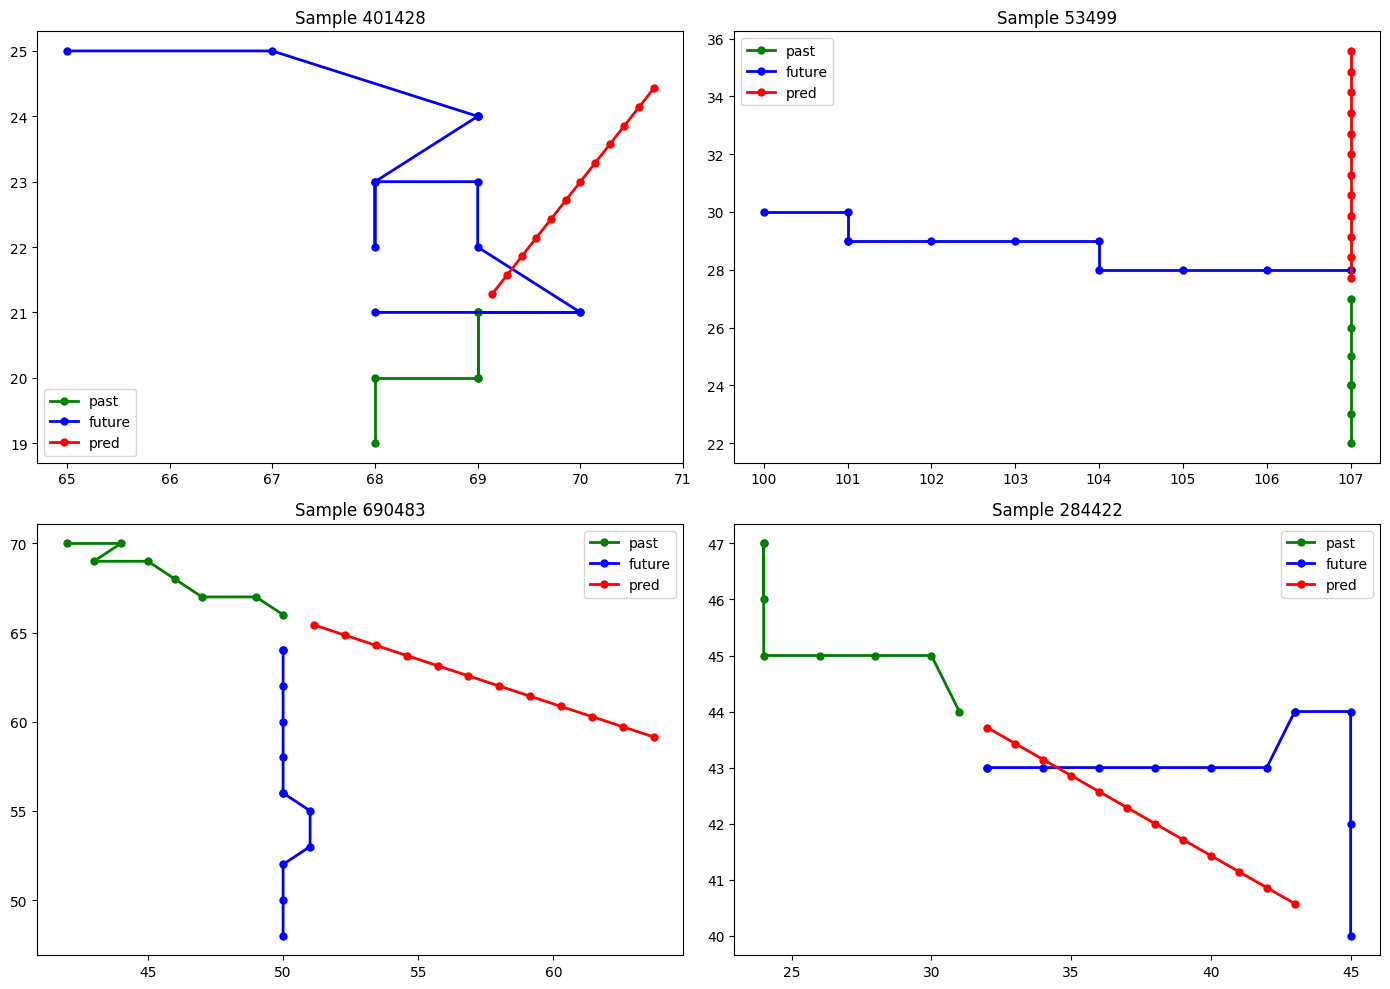

In [38]:
# Visualize trajectories by index

# Exact indices you want to plot
selected_indices = [401428, 53499, 690483, 284422]

rows = 2
cols = 2

plt.figure(figsize=(14, 10))

for i, idx in enumerate(selected_indices):
    X_sample = X_test[idx]
    Y_true   = Y_test[idx].reshape(FUTURE_STEPS, 2)

    Y_predicted   = Y_pred[idx] 

    past = X_sample.reshape(PAST_STEPS, 2)[:, :2]

    ax = plt.subplot(rows, cols, i + 1)

    # Past (green)
    ax.plot(
        past[:, 0], past[:, 1],
        'o-', color='green', markersize=5, linewidth=2,
        label='past'
    )

    # True future (blue)
    ax.plot(
        Y_true[:, 0], Y_true[:, 1],
        'o-', color='blue', markersize=5, linewidth=2,
        label='future'
    )

    # Predicted (red)
    ax.plot(
        Y_predicted[:, 0], Y_predicted[:, 1],
        'o-', color='red', markersize=5, linewidth=2,
        label='pred'
    )

    ax.set_title(f"Sample {idx}", fontsize=12)

    ax.legend()

    ax.grid(False)

plt.tight_layout()
plt.show()